## GPT LINK: https://chatgpt.com/share/67f8a93f-83b0-8008-b10d-3316b40a7563

In [112]:
#@title imports

import numpy as np
import matplotlib.pyplot as plt

In [121]:
#@title constants

G = 6.67430e-20 # km^3 / kg / s^2

mass_earth = 5.972e24 # kg
mass_moon = 7.348e22 # kg

pos_earth = np.array([-385000.6, 0.0]) # fixed earth position, km
pos_moon = np.array([0.0, 0.0]) # fixed moon position, km

# functions

# acceleration function [two body]
def acceleration(pos_sat, index):
  p_moon = pos_sat - pos_moon # position of the satellite with respect to the moon
  a_moon = -G * mass_moon * p_moon / np.linalg.norm(p_moon)**3 # acceleration of the satellite induced by the moon

  p_earth = pos_sat - pos_earth # position of the satellite with respect to the earth
  a_earth = -G * mass_earth * p_earth / np.linalg.norm(p_earth)**3 # acceleration of the satellite induced by the earth

  a_two_body = a_moon
  a_three_body = a_moon + a_earth

  if index == 2:
    return a_two_body
  elif index == 3:
    return a_three_body

# derivative function
def der(y, index):
  p_m = y[0:2]
  v_m = y[2:4]
  a_m = acceleration(p_m, index)
  return np.concatenate([v_m, a_m])

# runge kutta 4th order
def rk4(y, dt, index):
  y1 = dt * der(y, index)
  y2 = dt * der(y + (1/4)*y1, index)
  y3 = dt * der(y + (3/32)*y1 + (9/32)*y2, index)
  y4 = dt * der(y + (1932/2197)*y1 + (-7200/2197)*y2 + (7296/2197)*y3, index)
  y5 = dt * der(y + (436/216)*y1 + (-8)*y2 + (3680/513)*y3 + (-845/4104)*y4, index)
  y_rk4 = y + (25/216)*y1 + (0)*y2 + (1408/2565)*y3 + (2197/4104)*y4 + (-1/5)*y5
  return y_rk4

# runge kutta 5th order
def rk5(y, dt, index):
  y1 = dt * der(y, index)
  y2 = dt * der(y + (1/4)*y1, index)
  y3 = dt * der(y + (3/32)*y1 + (9/32)*y2, index)
  y4 = dt * der(y + (1932/2197)*y1 + (-7200/2197)*y2 + (7296/2197)*y3, index)
  y5 = dt * der(y + (436/216)*y1 + (-8)*y2 + (3680/513)*y3 + (-845/4104)*y4, index)
  y6 = dt * der(y + (-8/27)*y1 + (2)*y2 + (-3544/2565)*y3 + (1859/4104)*y4 + (-11/40)*y5, index)
  y_rk5 = y + (16/135)*y1 + (0)*y2 + (6656/12825)*y3 + (28561/56430)*y4 + (-9/50)*y5 + (2/55)*y6
  return y_rk5

In [114]:
#@title satellite position function

def sat_pos_func(good_list):

  # initial satellite conditions
  alt = good_list[0]
  p_sat = np.array([1737.4 + alt, 0.0]) # km
  v_sat = np.array([0.0, np.sqrt(G*mass_moon/p_sat[0])]) # km/s

  # initial state
  y_static_4 = np.concatenate([p_sat, v_sat])
  y_static_5 = np.concatenate([p_sat, v_sat])
  y_dynamic = np.concatenate([p_sat, v_sat])

  # integration setup
  if good_list[5] == 2:
    t_end = np.sqrt((4 * np.pi**2 * p_sat[0]**3)/(G*mass_moon)) # two body
  elif good_list[5] == 3:
    t_end = good_list[1] # three body

  # static
  t_static = 0
  dt_static = good_list[2] # 1

  sat_pos_4 = []
  sat_pos_5 = []
  times_static = []

  while t_static < t_end:
      if t_static + dt_static > t_end:
          dt_static = t_end - t_static

      y4_static = rk4(y_static_4, dt_static, good_list[5])
      y5_static = rk5(y_static_5, dt_static, good_list[5])

      y_static_4 = y4_static
      y_static_5 = y5_static
      t_static += dt_static

      sat_pos_4.append(y_static_4[0:2])
      sat_pos_5.append(y_static_5[0:2])
      times_static.append(t_static)

  sat_pos_4 = np.array(sat_pos_4)
  sat_pos_5 = np.array(sat_pos_5)

  # dynamic
  t_dynamic = 0
  dt_dynamic = good_list[3] # 1e-8
  tol = good_list[4] # 1e-8

  sat_pos_45 = []
  times_dynamic = []

  while t_dynamic < t_end:
      if t_dynamic + dt_dynamic > t_end:
          dt_dynamic = t_end - t_dynamic

      y4_dynamic = rk4(y_dynamic, dt_dynamic, good_list[5])
      y5_dynamic = rk5(y_dynamic, dt_dynamic, good_list[5])

      error = np.linalg.norm(y5_dynamic - y4_dynamic) / (np.linalg.norm(y5_dynamic)) + 1e-20
      dt_dynamic *= min(4, max(0.1, 0.84 * (tol / error)**0.25))

      y_dynamic = y4_dynamic
      t_dynamic += dt_dynamic
      sat_pos_45.append(y_dynamic[0:2])
      times_dynamic.append(t_dynamic)

  sat_pos_45 = np.array(sat_pos_45)

  return sat_pos_4, sat_pos_5, sat_pos_45, times_static, times_dynamic

In [115]:
#@title plot function

def plots_be_damned(tb4, tb5, tb45, index):
  plt.style.use("default")
  fig, ((ax1), (ax2), (ax3)) = plt.subplots(1, 3, figsize=(20, 6))

  # main plots

  # moon
  ax1.plot(pos_moon, color = "grey", marker = "o", label='moon (fixed)')
  ax2.plot(pos_moon, color = "grey", marker = "o", label='moon (fixed)')
  ax3.plot(pos_moon, color = "grey", marker = "o", label='moon (fixed)')

  # earth
  if index == 4:
    ax1.plot(pos_earth[0], pos_earth[1], color = "darkcyan", marker = "o", label='earth (fixed)')
    ax2.plot(pos_earth[0], pos_earth[1], color = "darkcyan", marker = "o", label='earth (fixed)')
    ax3.plot(pos_earth[0], pos_earth[1], color = "darkcyan", marker = "o", label='earth (fixed)')

  # satellite
  ax1.plot(tb4[:, 0], tb4[:, 1], label='satellite trajectory [rk4]', color='limegreen')
  ax2.plot(tb5[:, 0], tb5[:, 1], label='satellite trajectory [rk5]', color='limegreen')
  ax3.plot(tb45[:, 0], tb45[:, 1], label='satellite trajectory [rk45]', color='limegreen')

  # tie fighters
  if index == 4:
    temp1 = int(np.size(tb4[:,0]) * 1/1.5)
    temp2 = int(np.size(tb5[:,0]) * 1/2)
    temp3 = int(np.size(tb45[:,0]) * 1/3)

    ax1.plot(tb4[temp1][0], tb4[temp1][1], marker = "$[ o ]$", markersize = 15, color = "black")
    ax2.plot(tb5[temp2][0], tb5[temp2][1], marker = "$[ o ]$", markersize = 15, color = "black")
    ax3.plot(tb45[temp3][0], tb45[temp3][1], marker = "$[ o ]$", markersize = 15, color = "black")

  title = ""
  if index == 2:
    title = "two body problem"
  elif index == 3:
    title = "three body problem"

  # axis set ups
  #ax1.set_title(f'satellite orbiting the moon [{title}]')
  ax1.set_ylabel('y [km]')
  ax1.set_xlim(-10000, 10000)
  ax1.set_ylim(-10000, 10000)
  ax1.axis('equal')
  ax1.legend(loc = "upper right")
  ax1.grid()

  ax2.set_title(f'satellite orbiting the moon [{title}]')
  ax2.set_xlabel('x [km]')
  ax2.set_xlim(-10000, 10000)
  ax2.set_ylim(-10000, 10000)
  ax2.axis('equal')
  ax2.legend(loc = "upper right")
  ax2.grid()

  ax3.axis('equal')
  ax3.legend(loc = "upper right")
  ax3.grid()

  plt.show()

In [118]:
#@title get position data

# altitude of satellite, time period, static time step, dynamic time step, tolerance, two or three body clause

# two body
inputs_two_body = np.array([200, 404, 1, 1, 1e-8, 2]) # time period does not matter for two body since it will be defined in the function
two_body_4, two_body_5, two_body_45, two_body_static, two_body_dynamic = sat_pos_func(inputs_two_body)

# three body
time = 3600 * 24

inputs_three_body = np.array([500, time, 1, 1e-8, 1e-8, 3]) # takes about 4 min to solve
three_body_4, three_body_5, three_body_45, three_body_static, three_body_dynamic = sat_pos_func(inputs_three_body)

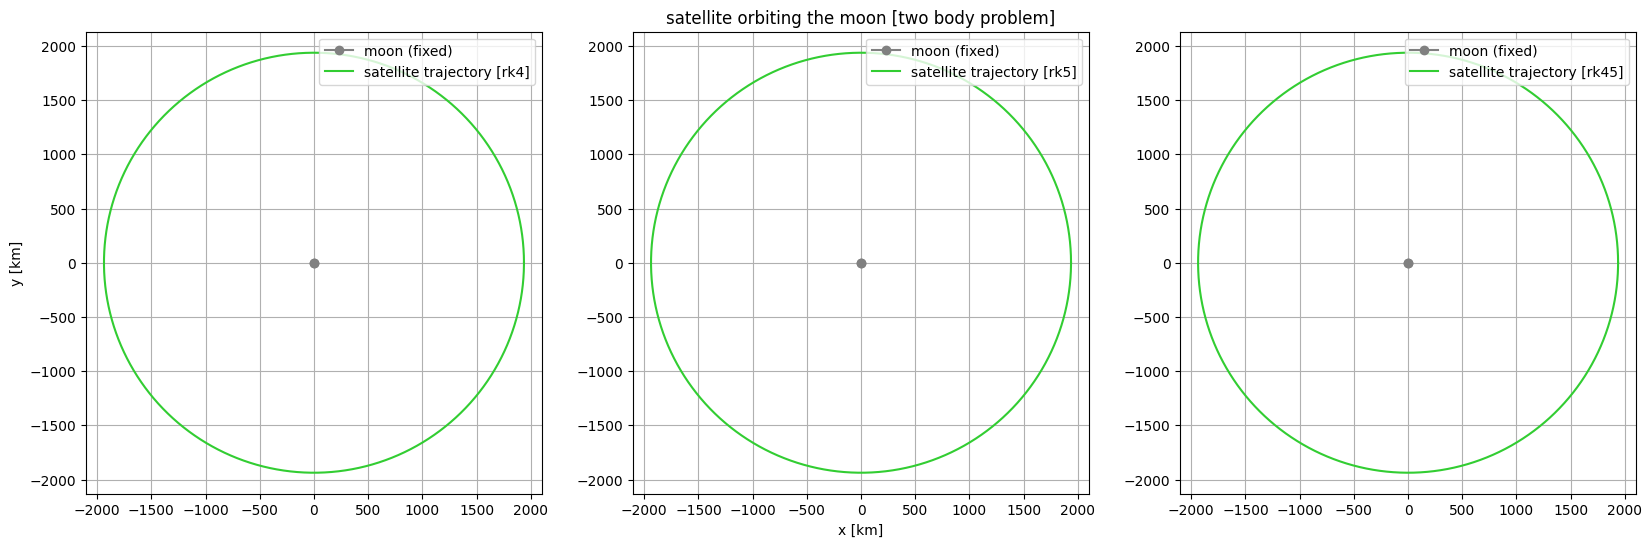

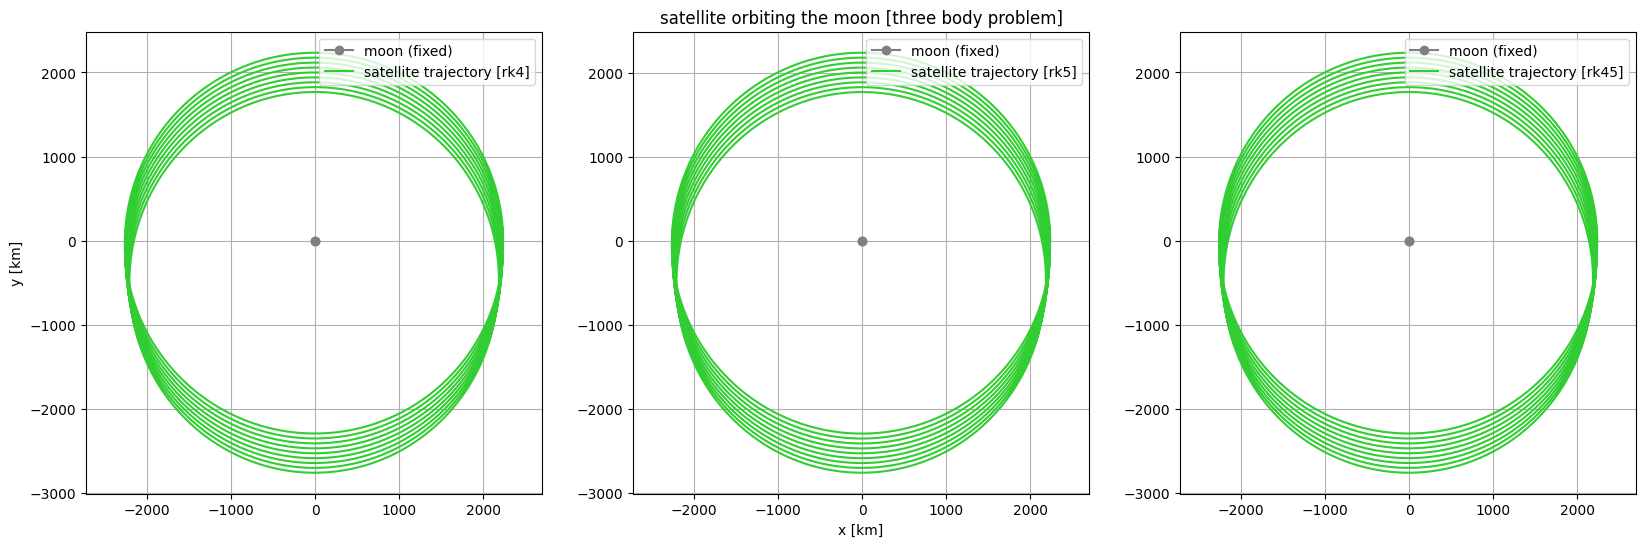

In [119]:
#@title graphs

plots_be_damned(two_body_4, two_body_5, two_body_45, inputs_two_body[5])
plots_be_damned(three_body_4, three_body_5, three_body_45, inputs_three_body[5])

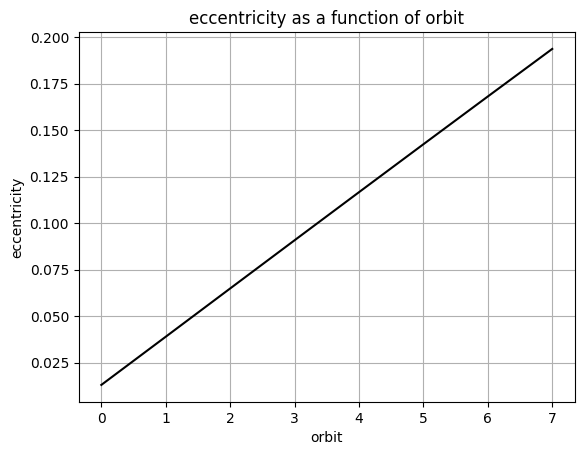

In [120]:
#@title eccentricity plots

def eccentricity(pos_func):
  x_vals = pos_func[:,0]
  y_vals = pos_func[:,1]

  orbits = []
  orbits_ind = []
  for i in range(len(y_vals)):
    point = [x_vals[i], y_vals[i]]
    if i != len(y_vals):
      if y_vals[i-1] < 0 and y_vals[i] > 0 and i != 0:
        orbits.append(orbits_ind)
        orbits_ind = []
        orbits_ind.append(point)
      else:
        orbits_ind.append(point)

  for i in range(len(orbits)):
    orbits[i] = np.array(orbits[i])

  ecc = []
  for i in orbits:
    norm_list = []
    for j in i:
      norm_list.append(float(np.linalg.norm(j)))
    b = np.min(norm_list)
    a = np.max(norm_list)
    ecc.append((a-b)/(a+b))

  return ecc

ecc1 = eccentricity(three_body_45)

plt.plot(ecc1, label = "eccentricity as a function of orbit", color = "black")

plt.title('eccentricity as a function of orbit')
plt.xlabel('orbit')
plt.ylabel('eccentricity')
#plt.ylim(0, 1)
#plt.legend()
plt.grid()
plt.show()

In [ ]:
#@title satellite orbiting moon [3 body, rk45]

import numpy as np
import matplotlib.pyplot as plt

# constants in km and kg
G = 6.67430e-20 # km^3 / kg / s^2
mass_earth = 5.972e24 # kg
mass_moon = 7.348e22 # kg

# fixed earth and moon positions
pos_earth = np.array([-385000.6, 0.0])
pos_moon = np.array([0.0, 0.0])

# initial satellite conditions
alt = 20000 # km
p_sat = np.array([1737.4 + alt, 0.0]) # km
v_sat = np.array([0.0, np.sqrt(G*mass_moon/p_sat[0])]) # km/s

# initial state
y = np.concatenate([p_sat, v_sat])

def acceleration(pos_sat):
    p_moon = pos_sat - pos_moon # position of the satellite with respect to the moon
    a_moon = -G * mass_moon * p_moon / np.linalg.norm(p_moon)**3 # acceleration of the satellite induced by the moon

    p_earth = pos_sat - pos_earth # position of the satellite with respect to the earth
    a_earth = -G * mass_earth * p_earth / np.linalg.norm(p_earth)**3 # acceleration of the satellite induced by the earth

    a_tot = a_moon + a_earth
    return a_tot

# derivative function
def der(y, dt):
    p_m = y[0:2]
    v_m = y[2:4]
    a_m = acceleration(p_m)
    return np.concatenate([v_m, a_m])

# runge kutta
def rk4(y, dt):
  y1 = dt * der(y, dt)
  y2 = dt * der(y + (1/4)*y1, dt)
  y3 = dt * der(y + (3/32)*y1 + (9/32)*y2, dt)
  y4 = dt * der(y + (1932/2197)*y1 + (-7200/2197)*y2 + (7296/2197)*y3, dt)
  y5 = dt * der(y + (436/216)*y1 + (-8)*y2 + (3680/513)*y3 + (-845/4104)*y4, dt)
  y_rk4 = y + (25/216)*y1 + (0)*y2 + (1408/2565)*y3 + (2197/4104)*y4 + (-1/5)*y5
  return y_rk4

def rk5(y, dt):
  y1 = dt * der(y, dt)
  y2 = dt * der(y + (1/4)*y1, dt)
  y3 = dt * der(y + (3/32)*y1 + (9/32)*y2, dt)
  y4 = dt * der(y + (1932/2197)*y1 + (-7200/2197)*y2 + (7296/2197)*y3, dt)
  y5 = dt * der(y + (436/216)*y1 + (-8)*y2 + (3680/513)*y3 + (-845/4104)*y4, dt)
  y6 = dt * der(y + (-8/27)*y1 + (2)*y2 + (-3544/2565)*y3 + (1859/4104)*y4 + (-11/40)*y5, dt)
  y_rk5 = y + (16/135)*y1 + (0)*y2 + (6656/12825)*y3 + (28561/56430)*y4 + (-9/50)*y5 + (2/55)*y6
  return y_rk5

# integration setup
t = 0
t_end = np.sqrt((4 * np.pi**2 * p_sat[0]**3)/(G*mass_moon)) # full orbit [circular]
t_end = 3600 * 24 * 5
dt = 1e-8
tol = 1e-8

sat_pos_45 = []
times = []

while t < t_end:
    if t + dt > t_end:
        dt = t_end - t

    y4 = rk4(y, dt)
    y5 = rk5(y, dt)

    error = np.linalg.norm(y5 - y4) / (np.linalg.norm(y5)) + 1e-20
    dt *= min(4, max(0.1, 0.84 * (tol / error)**0.25))

    y = y4
    t += dt
    sat_pos_45.append(y[0:2])
    times.append(t)

sat_pos_45 = np.array(sat_pos_45)

# plot
plt.style.use("default")
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

ax1.grid(True, color='darkgrey', linestyle='-', linewidth=1, zorder=0)

ax1.plot(pos_moon, color = "grey", marker = "o", label='moon (fixed)') # moon
ax1.plot(pos_earth[0], pos_earth[1], color = "darkcyan", marker = "o", label='earth (fixed)') # earth
ax1.plot(sat_pos_45[:, 0], sat_pos_45[:, 1], label='satellite trajectory', color='limegreen') # satellite orbit
temp = int(np.size(sat_pos_45[:,0]) * 1/1.3)
ax1.plot(sat_pos_45[temp][0], sat_pos_45[temp][1], marker = "$[ o ]$", markersize = 15, color = "black")

ax1.set_title('satellite orbiting the moon (RK45, km units)')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.legend(loc = "upper right")
ax1.axis('equal')

plt.show()